In [1]:
import requests
from transformers import AutoProcessor, AutoModelForVision2Seq
from PIL import Image
import torch

torch.cuda.is_available()

2024-09-18 13:35:36.633179: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


True

In [2]:
import transformers
transformers.__version__

'4.44.2'

# Load Tokenizer/ Processor

In [3]:
from pprint import pprint

model_id = "HuggingFaceM4/idefics2-8b"
processor = AutoProcessor.from_pretrained(model_id)
model = AutoModelForVision2Seq.from_pretrained(model_id, device_map="auto")
pprint(processor.chat_template)

Chat templates should be in a 'chat_template.json' file but found key='chat_template' in the processor's config. Make sure to move your template to its own file.


Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

("{% for message in messages %}{{message['role'].capitalize()}}{% if "
 "message['content'][0]['type'] == 'image' %}{{':'}}{% else %}{{': '}}{% endif "
 "%}{% for line in message['content'] %}{% if line['type'] == 'text' "
 "%}{{line['text']}}{% elif line['type'] == 'image' %}{{ '<image>' }}{% endif "
 '%}{% endfor %}<end_of_utterance>\n'
 "{% endfor %}{% if add_generation_prompt %}{{ 'Assistant:' }}{% endif %}")


# Load jinja template

In [4]:
from jinja2 import Environment, FileSystemLoader

template_dir = "./prompt_templates"

# Load the template from the file system
env = Environment(loader=FileSystemLoader(template_dir))

## Render with empty messages

In [5]:
template = env.get_template('multimodal_prompt.j2')
rendered_output = template.render(messages=[])
pprint(rendered_output)

('You are an advanced AI assistant designed for multimodal retrieval-augmented '
 'generation (RAG). Your responses should be based solely on the context '
 'provided to you, which may include both images and text. When answering user '
 'queries:\n'
 '1. Carefully analyze all provided context (images and text).\n'
 '2. Formulate your response using only the information present in this '
 'context.\n'
 '3. If the answer cannot be determined from the given context, clearly state: '
 "'I cannot answer this based on the provided information.'\n"
 'Do not use prior knowledge or make assumptions beyond what is explicitly '
 'provided. Your goal is to give accurate, relevant responses grounded in the '
 'given context.\n')


## Render with text messages

In [6]:
messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "text", 
                "text": "Hello, hopw are you?"
            },
        ]
    }
]

rendered_output = template.render(messages=messages)
pprint(rendered_output)

('You are an advanced AI assistant designed for multimodal retrieval-augmented '
 'generation (RAG). Your responses should be based solely on the context '
 'provided to you, which may include both images and text. When answering user '
 'queries:\n'
 '1. Carefully analyze all provided context (images and text).\n'
 '2. Formulate your response using only the information present in this '
 'context.\n'
 '3. If the answer cannot be determined from the given context, clearly state: '
 "'I cannot answer this based on the provided information.'\n"
 'Do not use prior knowledge or make assumptions beyond what is explicitly '
 'provided. Your goal is to give accurate, relevant responses grounded in the '
 'given context.\n'
 '\n'
 'User:\n'
 'Hello, hopw are you?')


## Render mutlimodal

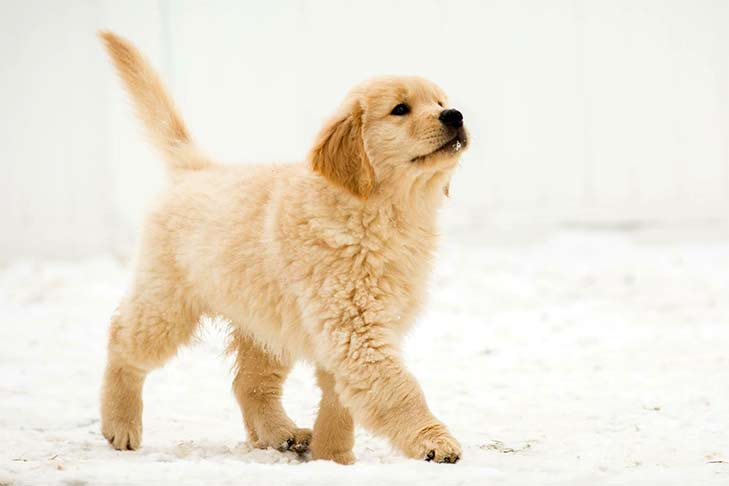

In [7]:
img_url = "https://www.akc.org/wp-content/uploads/2017/11/Golden-Retriever-Puppy.jpg"
img = Image.open(requests.get(img_url, stream=True).raw)
display(img)

In [8]:
messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image"
            },
            {
                "type": "text", 
                "text": "Hello, what can be seen on the image?"
            },
        ]
    }
]

import re

rendered_output = template.render(messages=messages)
pprint(rendered_output)

('You are an advanced AI assistant designed for multimodal retrieval-augmented '
 'generation (RAG). Your responses should be based solely on the context '
 'provided to you, which may include both images and text. When answering user '
 'queries:\n'
 '1. Carefully analyze all provided context (images and text).\n'
 '2. Formulate your response using only the information present in this '
 'context.\n'
 '3. If the answer cannot be determined from the given context, clearly state: '
 "'I cannot answer this based on the provided information.'\n"
 'Do not use prior knowledge or make assumptions beyond what is explicitly '
 'provided. Your goal is to give accurate, relevant responses grounded in the '
 'given context.\n'
 '\n'
 'User:\n'
 '<image>\n'
 '\n'
 'Hello, what can be seen on the image?')


In [9]:
inputs = processor(rendered_output, images=[img], return_tensors="pt")
inputs = {k: v.to("cuda") for k, v in inputs.items()}

inputs_length = len(inputs["input_ids"][0])

In [10]:
outputs = model.generate(**inputs, max_new_tokens=1_000).to("cpu")

In [11]:
processor.batch_decode(outputs, skip_special_tokens=True)

["You are an advanced AI assistant designed for multimodal retrieval-augmented generation (RAG). Your responses should be based solely on the context provided to you, which may include both images and text. When answering user queries:\n1. Carefully analyze all provided context (images and text).\n2. Formulate your response using only the information present in this context.\n3. If the answer cannot be determined from the given context, clearly state: 'I cannot answer this based on the provided information.'\nDo not use prior knowledge or make assumptions beyond what is explicitly provided. Your goal is to give accurate, relevant responses grounded in the given context.\n\nUser:\n \n\nHello, what can be seen on the image?\n\nThe image shows a puppy walking on a snowy surface. The puppy is light brown in color and has a fluffy coat. The background is white, indicating that the puppy is walking in a snowy area."]